# Setup

In [1]:
# import statements
import os
import pandas as pd
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios

# Griff's stuff
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt

import promoter_solving_core as ps
import GA_core as ga

from deap import algorithms, base, creator, tools
from sympy import *

In [16]:
# settings
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : False,
    'central_gene' : 'b1101',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # cAct & cInh Grid flags
    'cActivator' : [0,2], # Uses a log10 range
    'cInhibitor': [-1,4], # Uses a log10 range
    
    # GA - best cActivator/cInhibitor flags
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 1000, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook

    'n_iter' : 10, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 10, # Maximum number of steps before moving on to next condition
    'n_rounds' : 300, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b2143', 'b1817'] # if run_on_all is False, limit to these samples (or which of them are available)
}

# settings
'''
input_parameters = {
    # base condition for mRNA ratio generation parameters
    'gene_of_interest' : 'b2143', 
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest
    'control_value_log_tpm' : 10, # basal log tpm value hard set for now
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP

    # cActivator/cInhibitor GA parameters
    'seed' : 42, # Random seed to use with the np.random.Generator object
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 1000, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook

    'n_iter' : 1, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual
}
'''

gene_to_act_inh_iMs = {
    'b1101' : ['Crp-2', 'DhaR/Mlc'],
    'b1817' : ['Crp-2', 'DhaR/Mlc'],
    'b1818' : ['Crp-2', 'DhaR/Mlc'],
    'b1819' : ['Crp-2', 'DhaR/Mlc'],
    'b2151' : ['Crp-1', 'Crp-2'],
    'b3601' : ['Crp-1', 'Crp-2'],
    'b2239' : ['Crp-2', 'GlpR'],
    'b2240' : ['Crp-2', 'GlpR'],
    'b0723' : ['Crp-2', 'ArcA-1'],
    'b1415' : ['Crp-2', 'Crp-1'],
    'b2597' : ['Crp-2', 'CpxR'],
    'b3403' : ['Crp-2', 'crp-KO'],
    'b4267' : ['Crp-2', 'GntR/TyrR'],
    'b2143' : ['Crp-2', 'YieP'],
}

# Grid constants, use these if basal_bool = False
# NOTE: The names of these variables must match the sympy equation
grid_constants = {
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6,
}

# Set reproducible random seed used by the GA
rng = np.random.default_rng(seed = flags['seed'])

In [3]:
# steps
# 1 - basal model calculations
# 2 - create mRNA ratios and MA values
# 3 - grid calculation for getting starting constants
# 4 - DEAP - calculate initial cActivator and cInhibitor values
# 5 - greedy algorithm to improve cActivator and cInhibitor values
# 6 - run GAMs
# 7 - convert back to mRNA ratios, plot predictions

# basal model calculations

# create mRNA ratios and MA values

In [4]:
# reads / creates the ratio dataframe
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
if not flags['force_rerun'] and os.path.exists('../data/saved_mRNA_ratios_MA_vals/'+df_name):
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
else:
    ratios_df = mRNA_ratios.calculate_mRNA_ratios_and_MA_values(gene_to_act_inh_iMs[flags['central_gene']][0], gene_to_act_inh_iMs[flags['central_gene']][1], flags)
    ratios_df.to_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name)

# Determine the Best cActivator and cInhibitor Values

## Create the Combined cAct and cInh Grid

### Histograms of Input Data

Text(0.5, 1.0, 'mRNA_ratio')

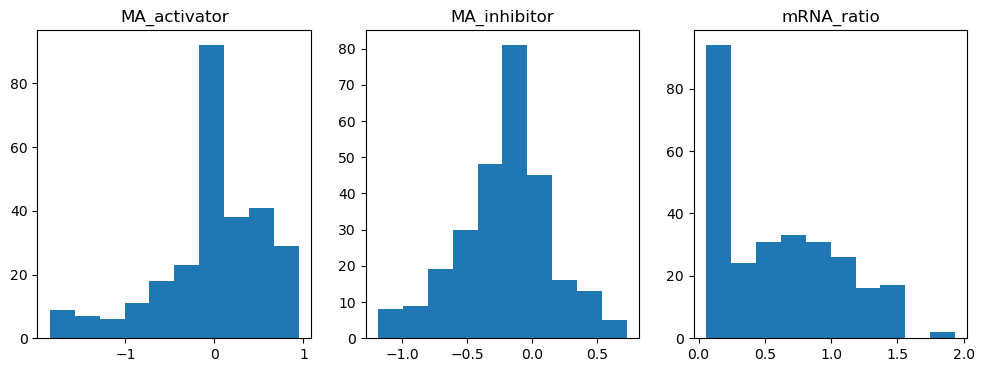

In [5]:
fig, [ax0, ax1, ax2] = plt.subplots(1,3, figsize=[12, 4])
ax0.hist(ratios_df.MA_activator)
ax0.set_title('MA_activator')

ax1.hist(ratios_df.MA_inhibitor)
ax1.set_title('MA_inhibitor')

ax2.hist(ratios_df.actual_mRNA_ratio)
ax2.set_title('mRNA_ratio')

### Create the Grid

In [6]:
# DataFrame to hold the Grid
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = ratios_df.index)
grid.loc[:,'mRNA_ratio'] = ratios_df.loc[:,'actual_mRNA_ratio']

# Load the equation
# NOTE: This equation was generated using Mathematica and Dan's Mathematica to Python converter function
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [7]:
# Create lambda functions that we can plug in to
lambda_df = ps.create_lambdas(equation, grid_constants)

cAct_range = {'cActivator': flags['cActivator']} # Use a log10 range
cInh_range = {'cInhibitor': flags['cInhibitor']} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = ps.create_parameter_grid(num_steps = 101, **cAct_range)
    cAct_grid = [[10**x[0]] for x in cAct_grid]
    cInh_grid = ps.create_parameter_grid(num_steps = 101, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function
        cAct_grid[ii] = (cAct_grid[ii][0], (lambda_df.loc['cInhibitor','lambda'](values_tuple))[0])

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0], cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids

    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Remove negative elements from working_grid
    working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]

    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [8]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,0.960705,"[(0.0018477823296865036, 0.1), (0.002271925086..."
control__wt_glc__2,1.040902,"[(0.005543617689519774, 0.1), (0.0060101107364..."
fur__wt_dpd__1,0.215516,"[(0.00204215426372842, 4.466835921509633), (0...."
fur__wt_dpd__2,0.216297,"[(0.002181818945635983, 4.466835921509633), (0..."
fur__wt_fe__1,0.771893,"[(0.00044186034961135075, 0.35481338923357547)..."


### Scatter Condition's Grid with Histograms

Text(0.5, 0.98, 'Condition: control__wt_glc__1')

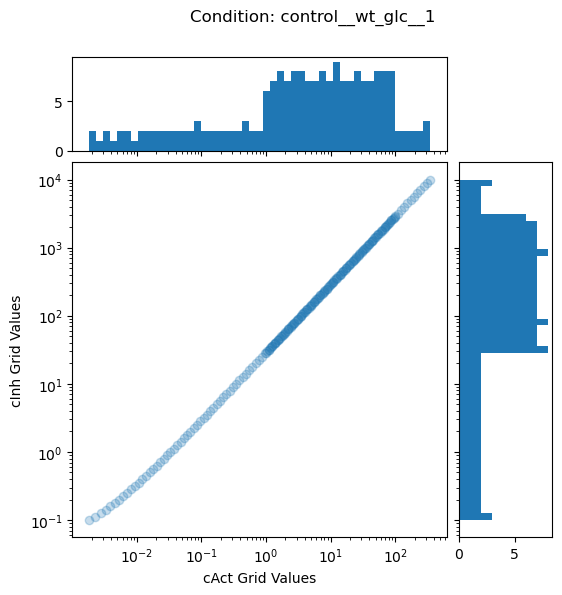

In [9]:
i = 0 # The integer corresponding to the condition of interest index

x = [cAct for (cAct, _) in grid.iloc[i,1]]
y = [cInh for (_, cInh) in grid.iloc[i,1]]

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# the scatter plot:
ax.scatter(x, y, alpha=0.25)

x_bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 50)
y_bins = np.logspace(np.log10(min(y)), np.log10(max(y)), 50)

ax_histx.hist(x, bins=x_bins)
ax_histy.hist(y, bins=y_bins, orientation='horizontal')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('cAct Grid Values')
ax.set_ylabel('cInh Grid Values')

fig.suptitle('Condition: '+str(grid.index[i]))

## Setup and Run the GA

In [10]:
# Create fitness and individual objects
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               shape = (len(grid),), # Number of conditions
               dtype = np.dtype([('act', float), ('inh', float)]), # Custom dtype
               fitness = creator.fitness)

# Import toolbox
toolbox = base.Toolbox()

# Register the individual and population functions
toolbox.register(alias = 'individual',
                 function = ga.generate_individual,
                 individual_class = creator.individual,
                 grid = grid.grid,
                 rng = rng)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

# Register the evaluation function
toolbox.register(alias = 'evaluate',
                function = ga.spearman_objective,
                MA_df = ratios_df.loc[:,['MA_activator','MA_inhibitor']])

# Register the selection algorithm
toolbox.register(alias = "select", 
                 function = tools.selNSGA2, 
                 nd = 'log') 
# I've been using selNSGA2 since it seems to run faster
#toolbox.register("select", tools.selSPEA2)

# Register the mutation function
toolbox.register(alias = 'mutate', 
                 function = ga.mutate, 
                 prob = flags['mt_prob'], 
                 grid = grid.grid, 
                 rng = rng)

# Register the crossover function
cx_prob = 0.6 # NOTE: These values were chosen based on brute_force.ipynb
toolbox.register(alias = "mate", 
                 function = ga.crossover, 
                 prob = flags['cx_prob'],
                 rng = rng)

# Set the statistics to record the best individual score of each generation in 
# the logbook
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],
                                                     ind.fitness.values[1]))

# Run the GA
pop, logbook = ga.mu_plus_lambda(pop = toolbox.population(n = flags['n_ind']), 
                                 toolbox = toolbox, 
                                 rng = rng, 
                                 mu = flags['mu'], 
                                 lambda_ = flags['lambda_'], 
                                 cxpb = flags['cxpb'], 
                                 mutpb = flags['mutpb'], 
                                 n_gen = flags['n_gen'], 
                                 stats = stats, 
                                 verbose = flags['verbose'])

### Check GA Results

In [11]:
total_score, total_sort = ga.best_individual(pop)
total_score[total_sort[-1]]

1.402628768438869

/var/folders/96/krcqhff13tdf7tndmxwbnkxr0000gn/T/ipykernel_35529/2869327454.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


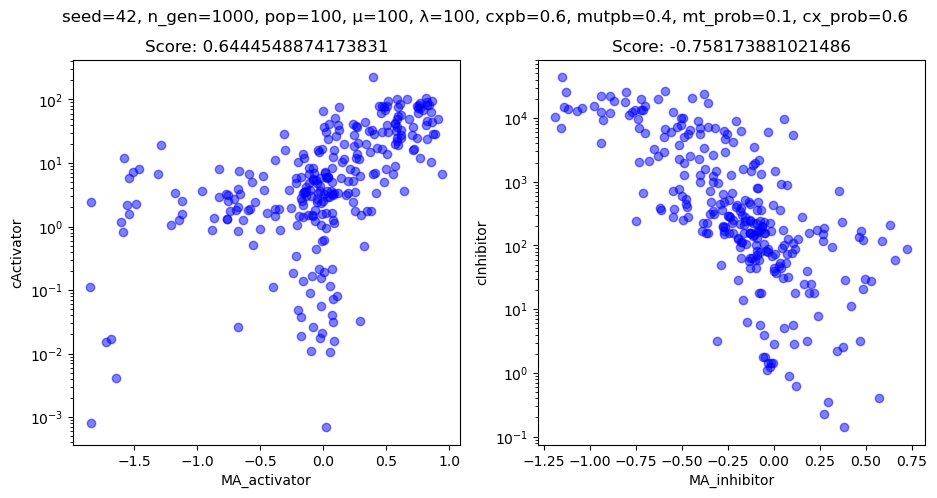

In [13]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = pop[total_sort[-1]],
                                     MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                     GA_parameters = flags)

fig.show()

## Run the Greedy Algorithm

In [17]:
greedy_pop = ga.greedy_algorithm(base_individual = pop[total_sort[-1]], 
                                 n_iterations = flags['n_iter'],
                                 grid = grid.grid,
                                 toolbox = toolbox,
                                 max_steps = flags['max_steps'],
                                 n_rounds = flags['n_rounds'])

greedy_score, greedy_sort = ga.best_individual(greedy_pop)
greedy_score[greedy_sort[-1]]

In [ ]:
greedy_voting = ga.voting(population = greedy_pop,
                          grid = grid.grid)

# Convert from condition integer index to grid tuple to create mean_ind
mean_ind = creator.individual(greedy_pop[greedy_sort[-1]])
for i, _ in enumerate(mean_ind):
    mean_ind[i] = grid.grid[i][int(greedy_voting.rounded_mean[i])]

mean_ind.fitness.values = toolbox.evaluate(mean_ind)
print(np.subtract(mean_ind.fitness.values[0], mean_ind.fitness.values[1]))

/var/folders/96/krcqhff13tdf7tndmxwbnkxr0000gn/T/ipykernel_1633/1893964657.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


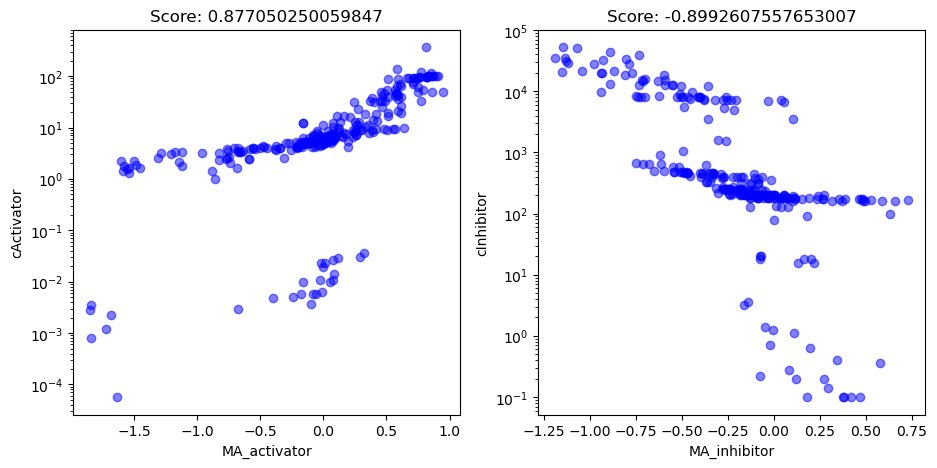

In [ ]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = greedy_pop[greedy_sort[-1]],
                                        ind_two = mean_ind
                                        MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                        GA_parameters = None)

fig.show()

### Convert Chosen Individual to DataFrame

In [18]:
GAMs_individual = greedy_pop[greedy_sort[-1]] # TODO: EDIT THIS USING FLAGS?

vals_for_GAMs = pd.DataFrame(index = ratios_df.index,
                             columns = ['cAct', 'cInh'],)

vals_for_GAMs.cAct = list(GAMs_individual['act'])
vals_for_GAMs.cInh = list(GAMs_individual['inh'])

In [19]:
vals_for_GAMs

,cAct,cInh
control__wt_glc__1,6.179767,177.827941
control__wt_glc__2,6.800323,177.827941
fur__wt_dpd__1,3.162278,465.794898
fur__wt_dpd__2,3.311311,485.723852
fur__wt_fe__1,5.374720,199.526231
...,...,...
efeU__menFentCubiC_ale36__2,4.158059,125.892541
efeU__menFentCubiC_ale37__1,4.786301,179.827339
efeU__menFentCubiC_ale37__2,5.105932,199.526231
efeU__menFentCubiC_ale38__1,7.244360,259.272666


### Save for GAMs (Avoid Overwriting Existing Files)

In [36]:
# save for GAMs
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
file_out = '../data/save_for_GAMs/'+df_name
vals_for_GAMs.to_csv(file_out)

In [20]:
df_name

'b1101_zerodTrue_mRNA_ratios_and_MA_vals.csv'

# run GAMs

In [63]:
# first let's merge together the files
files_use = []
if flags['run_on_all']:
    files = os.listdir('../data/save_for_GAMs/')
    for f in files:
        if 'composite' in f: continue
        if 'zerod'+str(flags['use_zerod_A_matrix']) not in f: continue
        files_use.append(f)
else:
    for sample in flags['limit_samples']:
        f_name = sample+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
        if os.path.exists('../data/save_for_GAMs/'+f_name):
            files_use.append(f_name)
for f in files_use:
    act_df = pd.DataFrame(index = ratios_df.index)
    inh_df = pd.DataFrame(index = ratios_df.index)
    for file in files_use:
        gene_name = file.split('_')[0]
        act_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file)['cAct'].values
        inh_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file)['cInh'].values
act_df.to_csv('../data/save_for_GAMs/composite_cAct_vals.csv')
inh_df.to_csv('../data/save_for_GAMs/composite_cInh_vals.csv')

In [62]:
# this is not directly integrated, to run this part:
# 1 - move the two composite csv files from ../data/save_for_GAMs/ to  Dropbox (UCSD SBRG)\TRN_iM_modeling\GAMS\chris_testing\input
# 2 - Load toy_model_v2.gms from \Dropbox (UCSD SBRG)\TRN_iM_modeling\GAMS\chris_testing\
# 3 - run model
# 4 - move excel files from Dropbox (UCSD SBRG)\TRN_iM_modeling\GAMS\chris_testing\output to ../data/GAMS_output

# convert back to mRNA ratios

# plotting